In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sk
import re 
import cv2
import json
import collections
import tensorflow
import keras
from time import time 
import nltk
import pickle
# from nltk.corpus import stopwards
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50,preprocess_input
from keras.models import Model,load_model
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing import image
from keras.utils import to_categorical
from keras.layers import Dropout,Dense,Flatten,Input,LSTM,Embedding
from keras.layers.merge import add

Using TensorFlow backend.


# Read Text Data Function

In [2]:
def readtextfiles(path):
    
    with open (path) as f:
        
        captions = f.read()
        
    return captions

# Read Captions of images 

In [3]:
captions = readtextfiles('/home/manik/Downloads/flickr8k (1)/flickr_data/Flickr_Data/Flickr_TextData/Flickr8k.token.txt')

# create dictionary of the captions with image as key

captions=captions.split('\n')

captions = captions[:-1]

description = {}

for x in captions:
    
    first,second = x.split('\t')
    
    image_id = first.split('.')[0]
    
    if  description.get(image_id) is None:
        
        description[image_id]=[]
        
    description[image_id].append(second)


# Data Cleaning 

In [4]:
def clean_txt(sentence):
    
    sentence = sentence.lower()
    
    sentence = re.sub("[^a-z]+"," ",sentence)
    
    sentence=sentence.split(" ")
    
    sentence = [s for s in sentence if len(s)>1]
    
    sentence =" ".join(sentence)
    
    return sentence


for key,captions in description.items():
    
    for i in range(len(captions)):
        
        captions[i]=clean_txt(captions[i])
    
with open("/home/manik/Downloads/flickr8k (1)/Description_of_images.txt","w") as f:
    
    f.write(str(description))

# Create A vocab

In [5]:
with open("/home/manik/Downloads/flickr8k (1)/Description_of_images.txt","r") as f:
    
    description = f.read()
    
description = json.loads(description.replace("'","\""))

unique_word = set()

for key in description.keys():
    
    [unique_word.update(sentence.split()) for sentence in description[key]]
    
total_word = []

for key in description.keys():
    
    [total_word.append(word) for sentence in description[key] for word in sentence.split()]

Count = collections.Counter(total_word)

vocab = set()

for word in unique_word:
     if Count[word]>10:
            vocab.add(word)

vocab.add("startseq")
vocab.add("endseq")

# Prepare Train And Test Data

In [6]:

with open("/home/manik/Downloads/flickr8k (1)/Flickr_Data/Flickr_Data/Flickr_TextData/Flickr_8k.trainImages.txt") as f:
   
    train_data = f.read().split("\n")[:-1]
    

with open("/home/manik/Downloads/flickr8k (1)/Flickr_Data/Flickr_Data/Flickr_TextData/Flickr_8k.testImages.txt") as f:
   
    test_data =f.read().split("\n")[:-1]
    

train_description = {}

for image_id in train_data:
    
    image_id = image_id.split(".")[0]
    
    train_description[image_id] = []
    
    for x in description[image_id]:
        
        train_description[image_id].append("startseq "+x+" endseq")
    


# Image Feature Extraction

In [7]:
model = ResNet50(weights="imagenet",input_shape=(224,224,3))

model.summary()


Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
_________

In [8]:
model_new=Model(model.input,model.layers[-2].output)

def preprocess_img(img):
    
    img=image.load_img(img,target_size=(224,224))
    
    img=image.img_to_array(img)
    
    img=np.expand_dims(img,axis=0)
    
    # normalisation
    
    img=preprocess_input(img)
    
    return img
    
    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


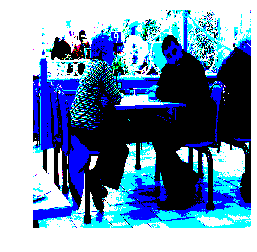

In [9]:
img=preprocess_img("/home/manik/Downloads/flickr8k (1)/Flickr_Data/Flickr_Data/Images/2206594874_5e0087c6b7.jpg")
plt.imshow(img[0])
plt.axis("off")
plt.show()

In [10]:
def encode(img):
    
    img=preprocess_img(img)
    
    feature_vector=model_new.predict(img)
    
    feature_vector=feature_vector.reshape((-1,))
        
    return feature_vector


In [11]:


IMG_PATH="/home/manik/Downloads/flickr8k (1)/Flickr_Data/Flickr_Data/Images/"

encoding_train={}

start =time()

for i ,img_id in enumerate(train_data):
    
    img=IMG_PATH+img_id
    
    encoding_train[img_id]=encode(img)
    
    if i%100==0:
        print("IN Progress",end=" ")
        print(i)
              
        
end_t=time()

print("time taken %d"%(end_t-start))

    
    
    
    
# encode("/home/manik/Downloads/flickr8k (1)/Flickr_Data/Flickr_Data/Images/2206594874_5e0087c6b7.jpg")


IN Progress 0
IN Progress 100
IN Progress 200
IN Progress 300
IN Progress 400
IN Progress 500
IN Progress 600
IN Progress 700
IN Progress 800
IN Progress 900
IN Progress 1000
IN Progress 1100
IN Progress 1200
IN Progress 1300
IN Progress 1400
IN Progress 1500
IN Progress 1600
IN Progress 1700
IN Progress 1800
IN Progress 1900
IN Progress 2000
IN Progress 2100
IN Progress 2200
IN Progress 2300
IN Progress 2400
IN Progress 2500
IN Progress 2600
IN Progress 2700
IN Progress 2800
IN Progress 2900
IN Progress 3000
IN Progress 3100
IN Progress 3200
IN Progress 3300
IN Progress 3400
IN Progress 3500
IN Progress 3600
IN Progress 3700
IN Progress 3800
IN Progress 3900
IN Progress 4000
IN Progress 4100
IN Progress 4200
IN Progress 4300
IN Progress 4400
IN Progress 4500
IN Progress 4600
IN Progress 4700
IN Progress 4800
IN Progress 4900
IN Progress 5000
IN Progress 5100
IN Progress 5200
IN Progress 5300
IN Progress 5400
IN Progress 5500
IN Progress 5600
IN Progress 5700
IN Progress 5800
IN Progr

In [12]:
 with open ("Preprocessed_images.pkl","wb") as f:
    pickle.dump(encoding_train,f)

In [13]:
IMG_PATH="/home/manik/Downloads/flickr8k (1)/Flickr_Data/Flickr_Data/Images/"

encoding_test={}

for i, img_id in enumerate(test_data):
    
    img=IMG_PATH+img_id
    
    encoding_test[img_id]=encode(img)
    
    if i%100==0:
        print("IN Progress")
        
with open ("Preprocessed_test_images.pkl","wb") as f:
    pickle.dump(encoding_test,f)

IN Progress
IN Progress
IN Progress
IN Progress
IN Progress
IN Progress
IN Progress
IN Progress
IN Progress
IN Progress


# Caption Preprocessing

In [14]:
word_to_idx={}

idx_to_word={}

for i,word in enumerate(vocab):
    
    word_to_idx[word]=i+1
    
    idx_to_word[i+1]=word

maxlen=0

for key in train_description.keys():
    
    for cap in train_description[key]:
        
        maxlen=max(maxlen,len(cap.split()))
        
print(maxlen)

35


# Data Loader (Generator)

In [15]:
def data_generator(train_descriptions,encoding_train,word_to_idx,max_len,batch_size):
    X1,X2, y = [],[],[]
    
    n =0
    while True:
        for key,desc_list in train_descriptions.items():
            n += 1
            
            photo = encoding_train[key+".jpg"]
            for desc in desc_list:
                
                seq = [word_to_idx[word] for word in desc.split() if word in word_to_idx]
                for i in range(1,len(seq)):
                    xi = seq[0:i]
                    yi = seq[i]
                    
                    #0 denote padding word
                    xi = pad_sequences([xi],maxlen=max_len,value=0,padding='post')[0]
                    yi = to_categorical([yi],num_classes=len(vocab)+1)[0]
                    
                    X1.append(photo)
                    X2.append(xi)
                    y.append(yi)
                    
                if n==batch_size:
                    yield [[np.array(X1),np.array(X2)],np.array(y)]
                    X1,X2,y = [],[],[]
                    n = 0

# Word Embedding

In [16]:
f =open ('glove.6B.50d.txt',encoding='utf8')

In [17]:
embedding_idx ={}

for line in f:
    
    value=line.split()
    
    embedding_idx[value[0]]=np.array(value[1:],dtype="float")
    
def get_embedding_matrix():
    
    emd_dim=50
    
    matrix=np.zeros((len(vocab)+1,emd_dim))
    
    for word, idx in word_to_idx.items():
        
        embedding_vector=embedding_idx.get(word)
        
        if embedding_vector is not None:
            
            matrix[idx]=embedding_vector
        
    return matrix
    

In [18]:
embedding_matrix=get_embedding_matrix()
embedding_matrix.shape

(1848, 50)

# Model Architecture

In [19]:

inputs1 = Input(shape=(2048,))

fe1 = Dropout(0.3)(inputs1)

fe2 = Dense(256, activation='relu')(fe1)



inputs2 = Input(shape=(maxlen,))

se1 = Embedding(input_dim=len(vocab)+1,output_dim=50, mask_zero=True)(inputs2)

se2 = Dropout(0.3)(se1)

se3 = LSTM(256)(se2)



decoder1 = add([fe2, se3])

decoder2 = Dense(256, activation='relu')(decoder1)

outputs = Dense(len(vocab)+1, activation='softmax')(decoder2)



model = Model(inputs=[inputs1, inputs2], outputs=outputs)

model.summary()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 35)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 35, 50)       92400       input_3[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 2048)         0           input_2[0][0]                   

In [20]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable=False
model.compile(loss="categorical_crossentropy",optimizer="adam")

#  Train Model

In [21]:
epochs = 20

batch =3

steps =len(train_description)//5

def train():
    
    for i in range(epochs):
        
        generator = data_generator(train_description,encoding_train,word_to_idx,maxlen,batch)
        
        model.fit_generator(generator,epochs=1,steps_per_epoch=steps,verbose=1)
        
        model.save('/home/manik/model_m'+str(i)+'.h5')
        

In [22]:
train()

Epoch 1/1
1200/1200 [==============================] - 392s 327ms/step - loss: 4.5165
Epoch 1/1
1200/1200 [==============================] - 373s 311ms/step - loss: 3.7632
Epoch 1/1
1200/1200 [==============================] - 402s 335ms/step - loss: 3.4612
Epoch 1/1
1200/1200 [==============================] - 397s 330ms/step - loss: 3.2609
Epoch 1/1
1200/1200 [==============================] - 373s 311ms/step - loss: 3.1090
Epoch 1/1
1200/1200 [==============================] - 368s 307ms/step - loss: 2.9834
Epoch 1/1
1200/1200 [==============================] - 366s 305ms/step - loss: 2.8819
Epoch 1/1
1200/1200 [==============================] - 366s 305ms/step - loss: 2.7916
Epoch 1/1
1200/1200 [==============================] - 367s 305ms/step - loss: 2.7232
Epoch 1/1
1200/1200 [==============================] - 365s 305ms/step - loss: 2.6576
Epoch 1/1
1200/1200 [==============================] - 365s 304ms/step - loss: 2.6078
Epoch 1/1
1200/1200 [==============================] -

In [23]:
model = load_model("./model_m19.h5")

boy is swimming in pool


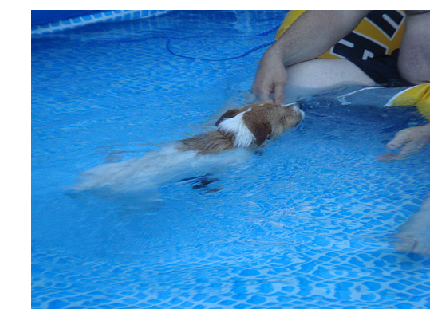

man and hiking are hiking on dirt path


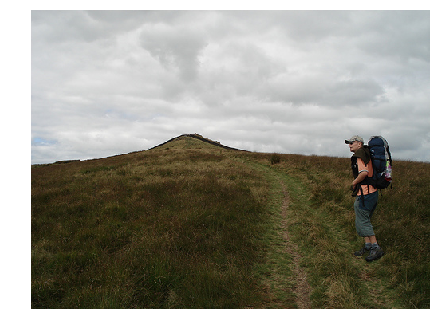

person in yellow jacket is snowboarding in the snow


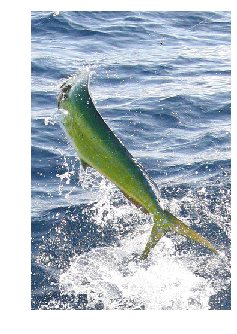

man is waterskiing on rock overlooking the ocean


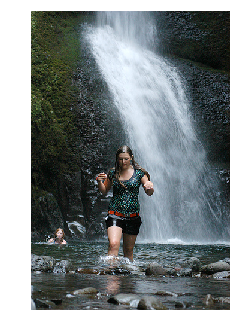

man is standing on the edge of wood building


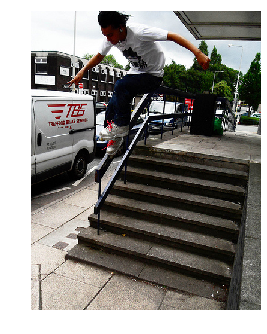

man in black jacket is smiling for picture


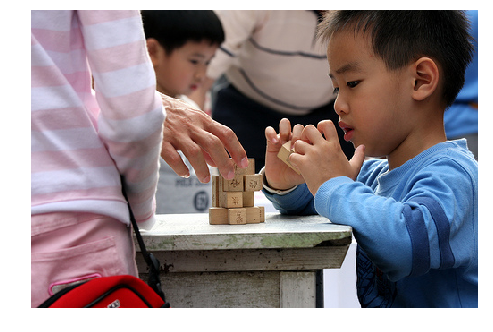

two people are standing on beach


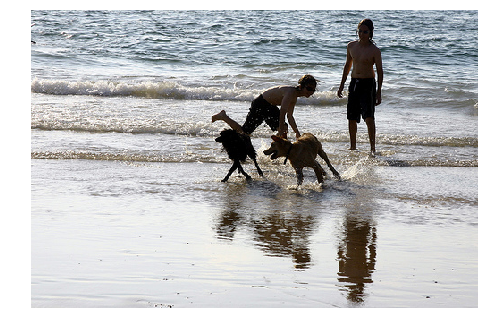

two dogs are playing in the water


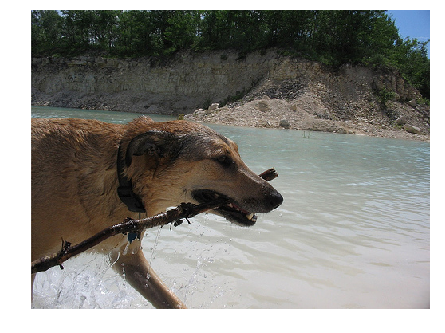

black and white dog jumps over red and white hurdle


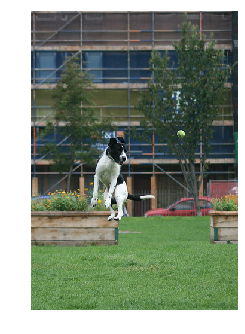

dog jumps into the air to catch frisbee in the water


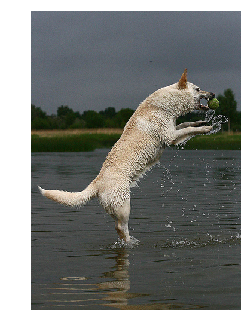

boy in blue shirt is backwards on swing


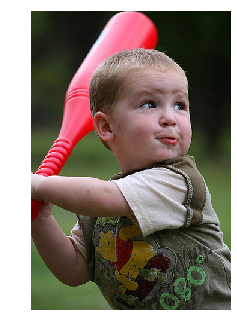

boy in swing


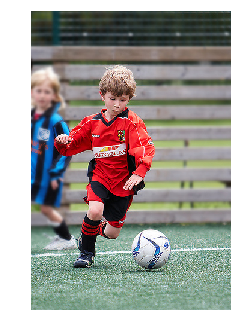

man in uniform bending cigarette


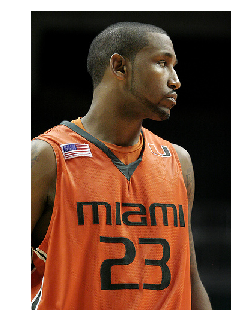

white dog with black collar is running through green yard


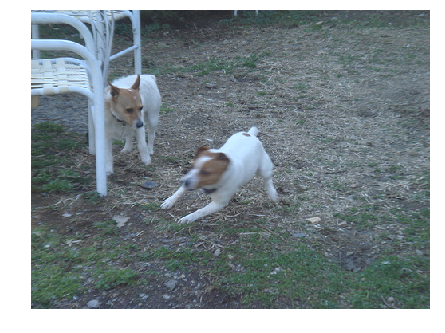

man in jeans is standing next to bus


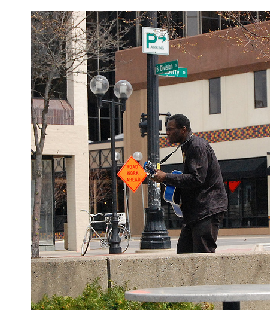

In [25]:
# def predict_caption(photo):
    
#     in_text="startseq"
    
#     for i in range(maxlen):
        
#         sequence=[word_to_idx[word] for word in in_text.split() if word in word_to_idx]
        
#         sequence =pad_sequences([sequence],padding="post",maxlen=maxlen)
        
#         ypred=model.predict([photo,sequence])
        
#         ypred=ypred.argmax()
        
#         word=idx_to_word[ypred]
        
#         in_text+=(" "+word)
        
#         if word=="endseq":
            
#             break;
            
#     final_caption =in_text.split()[1:-1]
       
#     final_caption =' '.join(final_caption)
        
#     return final_caption
    


# for i in range(20):
    
#     n=np.random.randint(0,1000)
    
#     img_id=list(encoding_test.keys())
    
#     img=img_id[n]
    
#     photo=IMG_PATH+img
    
#     photo_2048=encoding_test[img].reshape(1,2048)
    
#     caption = predict_caption(photo_2048)
    
#     print(caption)
    
#     img_2=plt.imread(photo)
    
#     plt.axis("off")
    
#     plt.imshow(img_2)
    
#     plt.show()
    
# #     print(predict_caption(photo_2048))
    

def predict_caption(photo):
    
    in_text = "startseq"
    for i in range(maxlen):
        sequence = [word_to_idx[w] for w in in_text.split() if w in word_to_idx]
        sequence = pad_sequences([sequence],maxlen=maxlen,padding='post')
        
        ypred = model.predict([photo,sequence])
        ypred = ypred.argmax() #WOrd with max prob always - Greedy Sampling
        word = idx_to_word[ypred]
        in_text += (' ' + word)
        
        if word == "endseq":
            break
    
    final_caption = in_text.split()[1:-1]
    final_caption = ' '.join(final_caption)
    return final_caption


# Pick Some Random Images and See Results
plt.style.use("seaborn")
for i in range(15):
    idx = np.random.randint(0,1000)
    all_img_names = list(encoding_test.keys())
    img_name = all_img_names[idx]
    photo_2048 = encoding_test[img_name].reshape((1,2048))
    
    i = plt.imread(IMG_PATH+img_name)
    
    caption = predict_caption(photo_2048)
    #print(caption)
    
    print(caption)
    plt.imshow(i)
    plt.axis("off")
    plt.show()
    
    
    
    
    